# Applying Super Resolution Generative Adversarial Network on FSR Matrix

Author: Roe Djer (Roger) Tan <br>
email: roetan@okstate.edu

### Notes:
Before running this code, please make sure you have `CUDA` installed to allow the code to be run using GPU instead of CPU. <br>
`CUDA` driver could be found on https://developer.nvidia.com/cuda-downloads

## Importing necessary library

In [14]:
pip install torch-directml


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder

from color_transfer import color_transfer

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

## Assigning parameters
- Set `load_pretrained_models` to **False** for the first time running the code or **True** if you wish to load previous model and continue training.
- The models will be saved in `/saved_models` folder. It will rewrite the saved models if you set `load_pretrained_models` to **False** and rerun the code. So, make sure you have a copy of saved models if you wish to rerun the code

In [16]:
import torch_directml

# Load pretrained models
load_pretrained_models = False
# Number of epochs of training
n_epochs = 20
# Size of the batches
batch_size = 6
# Adam: learning rate
lr = 0.0001
# Adam: decay of first order momentum of gradient
b1 = 0.5
# Adam: decay of second order momentum of gradient
b2 = 0.999
# Epoch from which to start lr decay
decay_epoch = 100
# Number of CPU threads to use during batch generation
n_cpu = 0
# High res. image height
hr_height = 256
# High res. image width
hr_width = 256
# HR LR shape
hr_shape = (256,256)
lr_shape = (64,64)
# Number of image channels
channels = 3

# Create directories if they don't exist
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Use DirectML device instead of CUDA
dml_device = torch_directml.device()

# You can now use this device for further operations
hr_shape = (hr_height, hr_width)

print("Using DirectML:", dml_device)


Using DirectML: privateuseone:0


## Creating ImageDataset Class 
- Data loading
- Data preprocessing including normalization, converting to RGB and tensors

In [17]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, hr_files, lr_files, hr_shape, lr_shape):
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize(hr_shape, Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize(lr_shape, Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_files = hr_files
        self.lr_files = lr_files
        self.hr_shape = hr_shape

    def __getitem__(self, index):
        img_hr = Image.open(self.hr_files[index % len(self.hr_files)]).convert("RGB")
        img_lr = Image.open(self.lr_files[index % len(self.lr_files)]).convert("RGB")
        img_lr = self.lr_transform(img_lr).to(dml_device)# added dml device
        img_hr = self.hr_transform(img_hr).to(dml_device)# added dml device

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.hr_files)



## Load Dataset

In [18]:
hr_path = "kriging_high"
lr_path = "kriging_low"
hr_files = sorted(glob.glob(hr_path + "/*.*"))
lr_files = sorted(glob.glob(lr_path + "/*.*"))
train_hr, test_hr, train_lr, test_lr = train_test_split(hr_files, lr_files, test_size=0.2, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_hr, train_lr, hr_shape=hr_shape, lr_shape=(lr_shape[0], lr_shape[1])), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_hr, test_lr, hr_shape=hr_shape, lr_shape=(lr_shape[0], lr_shape[1])), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

In [19]:
import os
os.getcwd()

'c:\\Users\\WangClinic\\Documents\\GitHub\\RowanPressureMappingCode'

## View preprocessed data

In [20]:
from PIL import Image

# select an image from high resolution folder
hr_path_test = r"kriging_high/hr_1.png"
lr_path_test = r"kriging_low/lr_1.png"

# create an instance of the ImageDataset class
dataset = ImageDataset([hr_path_test], [lr_path_test], hr_shape=(256, 256), lr_shape=(64, 64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


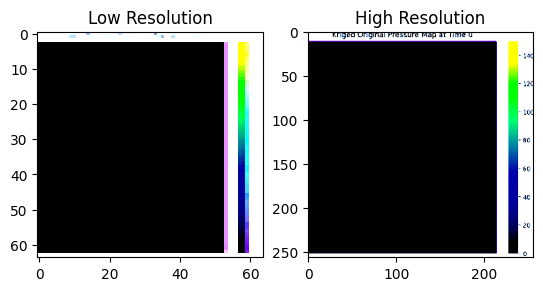

In [21]:
# # get the low resolution and high resolution images
# sample = dataset[0]
# img_lr, img_hr = sample['lr'], sample['hr']

# # show the low resolution and high resolution images
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(img_lr.permute(1, 2, 0))
# axs[0].set_title('Low Resolution')
# axs[1].imshow(img_hr.permute(1, 2, 0))
# axs[1].set_title('High Resolution')
# plt.show()

# Get the low resolution and high resolution images
sample = dataset[667]
img_lr, img_hr = sample['lr'], sample['hr']

# Move tensors to the CPU (if necessary) and convert to NumPy for visualization
img_lr = img_lr.cpu().permute(1, 2, 0)
img_hr = img_hr.cpu().permute(1, 2, 0)

# Show the low resolution and high resolution images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_lr.numpy())  # Convert to NumPy for display
axs[0].set_title('Low Resolution')
axs[1].imshow(img_hr.numpy())  # Convert to NumPy for display
axs[1].set_title('High Resolution')
plt.show()


## Building model blocks

| Class | Description |
|:--|:--|
|`FeatureExtractor`| A neural network module that extracts features from an input image using the VGG19 network architecture. Specifically, it uses the first 18 layers of the VGG19 model to extract image features. |
| `ResidualBlock` |  A neural network module that defines a residual block used in the GeneratorResNet. It contains two convolutional layers, each followed by batch normalization and PReLU activation function, and adds the input tensor to the output of the convolutions. |
| `GeneratorResNet` | A neural network module that generates high-resolution images from low-resolution images using a ResNet-like architecture with residual blocks. The input image is first processed by a 9x9 convolutional layer, followed by 16 residual blocks. Then, the output goes through another 3x3 convolutional layer before being upsampled using pixel shuffling. Finally, the output is processed by another 9x9 convolutional layer and Tanh activation function to generate the final output image. |
| `Discriminator` | A neural network module that discriminates between real and generated images. It takes an image as input and processes it through four convolutional blocks, each followed by batch normalization and LeakyReLU activation function. The output is then processed by a final convolutional layer to obtain a single output value, which represents the discriminator's confidence in the input image being real or generated. |

In [22]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=8, num_filters=64):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, num_filters, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(num_filters, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(num_filters, num_filters*4, 3, 1, 1),
                nn.BatchNorm2d(num_filters*4),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(num_filters, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

## Initialization of the SRGAN Model
- Initialize generator, discriminator, and feature extractor
- Set feature extractor to inference mode
- Define loss functions: criterion_GAN and criterion_content using MSELoss and L1Loss respectively
- Move the model and criterion to GPU if available
- Load pretrained models if specified
- Define optimizers for generator and discriminator using Adam optimizer with specified learning rate and betas
- Define Tensor type as either cuda.FloatTensor or torch.Tensor depending on whether GPU is available
- Define device as 'cuda' if GPU is available, otherwise 'cpu'

In [23]:
# Initialize generator and discriminator
generator = GeneratorResNet().to(dml_device)
discriminator = Discriminator(input_shape=(channels, *hr_shape)).to(dml_device)
feature_extractor = FeatureExtractor().to(dml_device)

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss().to(dml_device)
criterion_content = torch.nn.L1Loss().to(dml_device)


# if cuda:
#     generator = generator.cuda()
#     discriminator = discriminator.cuda()
#     feature_extractor = feature_extractor.cuda()
#     criterion_GAN = criterion_GAN.cuda()
#     criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("saved_models/generator.pth", map_location=dml_device))
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location=dml_device))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Learning rate scheduler (e.g., StepLR to reduce LR by a factor of 0.1 every 10 epochs)
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.1)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.1)
# Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.FloatTensor
device = dml_device

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\WangClinic/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


In [24]:
# print(torch.cuda.current_device())
# torch.cuda.get_device_name(0)
print("DirectML device initialized:", dml_device)

DirectML device initialized: privateuseone:0


In [25]:
import torch
torch.cuda.empty_cache()

## Training and testing

During training, the generator and discriminator are trained alternately. For each batch of low-resolution images, the generator generates high-resolution images which are then evaluated by the discriminator. The generator's loss is calculated as a combination of the adversarial loss and content loss. The discriminator's loss is calculated as the sum of the loss for real images and the loss for fake images. The total loss is the average of the two losses.

After each epoch of training, the generator and discriminator are evaluated on the test dataset. The losses for the generator and discriminator are calculated for the test dataset. An image grid with upsampled inputs and SRGAN outputs is also saved periodically.

If the generator loss for the current epoch is the lowest so far, the generator and discriminator models are saved as checkpoints.

In [26]:
from tqdm import tqdm

train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

# WGAN-GP Loss function
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(dml_device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), requires_grad=False).to(dml_device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

lambda_gp = 10

for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); 
        discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].to(dml_device))
        imgs_hr = Variable(imgs["hr"].to(dml_device))
        # Adversarial ground truths
        # valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        # fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        # valid = Variable(torch.ones((imgs_lr.size(0), *discriminator.output_shape)).to(dml_device), requires_grad=False)
        # fake = Variable(torch.zeros((imgs_lr.size(0), *discriminator.output_shape)).to(dml_device), requires_grad=False)
        valid = torch.ones((imgs_lr.size(0), *discriminator.output_shape), device=dml_device, requires_grad=False)
        # One-sided label smoothing for real labels
        # valid = torch.full((imgs_lr.size(0), *discriminator.output_shape), 0.9, device=dml_device, requires_grad=False)

        fake = torch.zeros((imgs_lr.size(0), *discriminator.output_shape), device=dml_device, requires_grad=False)


        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        if batch_idx % 5 == 0:
            ### Train Discriminator
            optimizer_D.zero_grad()
            # Loss of real and fake images
            loss_real = criterion_GAN(discriminator(imgs_hr), valid)
            loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, imgs_hr.data, gen_hr.data)
            # Total loss
            # loss_D = (loss_real + loss_fake) / 2
            loss_D = loss_real + loss_fake + lambda_gp * gradient_penalty
            loss_D.backward()
            optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].to(dml_device))
        imgs_hr = Variable(imgs["hr"].to(dml_device))
        # Adversarial ground truths
        # valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        # fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        valid = Variable(torch.ones((imgs_lr.size(0), *discriminator.output_shape)).to(dml_device), requires_grad=False)
        fake = Variable(torch.zeros((imgs_lr.size(0), *discriminator.output_shape)).to(dml_device), requires_grad=False)


        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))
        
        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            # Convert to uint8 before saving
            # img_grid = img_grid.to(dml_device)
            # img_grid = (img_grid.clamp(0, 1) * 255).byte()

            img_grid = img_grid.to('cpu')  # Ensure it's on CPU and in float32

            # Scale the image to [0, 255] and convert to uint8
            # img_grid = img_grid.clamp(0, 1).mul(255).byte() 

            save_image(img_grid, f"images/epoch{epoch}_{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))
    
    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

Testing Epoch 19 : 100%|██████████| 46/46 [00:04<00:00, 10.46it/s, disc_loss=1.94, gen_loss=0.225]


In [27]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Evaluation
- Train vs. Test Generator Loss (Investigating how well the generated images for each epoch are)
- Train vs. Test Discriminator Loss (Investigating how efficient the differentiating of real and fake generated images for each epoch does)

In [2]:
import plotly.graph_objects as go # added by Hunter
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()


NameError: name 'train_counter' is not defined

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()


## Sample generation of weight distribution matrix from low-resolution matrix using saved models
- Average normalized root mean squared error (NMSE), Average peak signal-to-noise ratio (PSNR), and Average structural similarity index (SSIM) were also calculated

In [30]:
import torch
from torchvision import transforms
from PIL import ImageEnhance
import random
from skimage import metrics

state_dict = torch.load("saved_models/generator.pth", map_location=dml_device)
generator = GeneratorResNet().to(dml_device)
generator.load_state_dict(state_dict)
generator.eval()  # set to evaluation mode

# Define the normalization parameters used in the ImageDataset class
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Inverse transform for transform
inv_transform = transforms.Compose(
    [ 
        transforms.Normalize(mean = [ 0., 0., 0. ],
                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                             std = [ 1., 1., 1. ]),
    ]

)

# Generate a list of 100 unique random integers between 0 and 4999
random_list = random.sample(range(901), 100)
random_list.extend([260, 200, 787]) 
all_nmse = 0
all_psnr = 0
all_ssim = 0
krig_nmse = 0
krig_psnr = 0
krig_ssim = 0


for i in random_list:
    lr_image = Image.open(f"kriging_high/hr_{i}.png").convert("RGB")
    hr_image = Image.open(f"kriging_low/lr_{i}.png").convert("RGB").resize((256,256), resample=Image.BICUBIC)
#    lr_image = lr_image.convert("RGB")
    lr_tensor = transforms.Compose(
        [
            transforms.Resize(lr_shape, Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )(lr_image)
    # lr_tensor = Variable(lr_tensor.unsqueeze(0), requires_grad=False)
    lr_tensor = lr_tensor.unsqueeze(0).to(dml_device) 
    lr_image = Image.open(f"kriging_high/hr_{i}.png").convert("RGB").resize((256,256), resample=Image.BICUBIC)
    with torch.no_grad():
        fake_hr_tensor = generator(lr_tensor)

    
    # Apply the inverse transform to the generated image tensor
    fake_hr_tensor = inv_transform(fake_hr_tensor)

    # Convert the denormalized tensor to a PIL image
    # fake_hr_image = transforms.ToPILImage()(fake_hr_tensor.squeeze(0))
    fake_hr_image = transforms.ToPILImage()(fake_hr_tensor.squeeze(0).to('cpu')) 
    
    #fake_hr_tensor = fake_hr_tensor.squeeze(0)  # remove batch dimension
    #fake_hr_tensor = (fake_hr_tensor + 1) / 2  # denormalize to [0, 1]
    #fake_hr_image = fake_hr_tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy()  # convert to numpy array and clamp to [0, 1]
    #fake_hr_image = (fake_hr_image * 255).astype("uint8")  # convert to uint8
    #fake_hr_image = Image.fromarray(fake_hr_image)  # convert to PIL Image
    fake_hr_image = fake_hr_image.resize(hr_image.size)

    # Create enhancer object
    enhancer = ImageEnhance.Brightness(fake_hr_image)

    # Reduce brightness by a factor of 0.5
    fake_hr_image = enhancer.enhance(1.0)

    # Increase the contrast by a factor of 1.5
    contrast = ImageEnhance.Contrast(fake_hr_image)
    fake_hr_image = contrast.enhance(1.2)
    fake_hr_image.save(f"random_generation//fake_{i}.png")  # or any other format
    # Convert the Pillow image back to a NumPy array
    fake_arr = np.array(fake_hr_image)

    real_arr = np.array(hr_image)
    lr_arr = np.array(lr_image)
    # Compute the scores
    ssim = metrics.structural_similarity(real_arr, fake_arr, win_size=3, multichannel=True)
    nmse = metrics.normalized_root_mse(real_arr, fake_arr)
    psnr = metrics.peak_signal_noise_ratio(real_arr, fake_arr)
    kssim = metrics.structural_similarity(real_arr, lr_arr, win_size=3, multichannel=True)
    knmse = metrics.normalized_root_mse(real_arr, lr_arr)
    kpsnr = metrics.peak_signal_noise_ratio(real_arr, lr_arr)
    
    
    all_nmse += nmse
    all_psnr += psnr
    all_ssim += ssim
    
    krig_nmse += knmse
    krig_psnr += kpsnr
    krig_ssim += kssim
    
    fake_hr_image.close()
    lr_image.close()
    hr_image.close()
    
print(f"Kriging Result:\n-------------------------------------")
print(f"Average normalized root mean squared error (NMSE): {krig_nmse/len(random_list):.4f}")
print(f"Average peak signal-to-noise ratio (PSNR): {krig_psnr/len(random_list):.4f}")
print(f"Average structural similarity index (SSIM): {krig_ssim/len(random_list):.4f}")
print(f"Kriging SRGAN Result:\n-------------------------------------")
print(f"Average normalized root mean squared error (NMSE): {all_nmse/len(random_list):.4f}")
print(f"Average peak signal-to-noise ratio (PSNR): {all_psnr/len(random_list):.4f}")
print(f"Average structural similarity index (SSIM): {all_ssim/len(random_list):.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'random_generation//fake_675.png'

In [ ]:
import torch
from torchvision import transforms
from PIL import Image, ImageEnhance
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics

# Load the pre-trained generator model
state_dict = torch.load("saved_models/generator.pth", map_location=dml_device)
generator = GeneratorResNet().to(dml_device)
generator.load_state_dict(state_dict)
generator.eval()  # Set to evaluation mode

# Define the normalization parameters used in the ImageDataset class
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Inverse transform for normalization
inv_transform = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

# Generate a list of 100 unique random integers between 0 and 4999
random_list = random.sample(range(5000), 100)
random_list.extend([260, 2005, 2787])  # Additional specific indices for comparison
all_nmse = 0
all_psnr = 0
all_ssim = 0
krig_nmse = 0
krig_psnr = 0
krig_ssim = 0

for i in random_list:
    # Load the high-resolution (HR) and low-resolution (LR) images
    hr_image = Image.open(f"kriging_high/hr_{i}.png").convert("RGB")
    lr_image = Image.open(f"kriging_low/lr_{i}.png").convert("RGB").resize((256, 256), resample=Image.BICUBIC)
    
    # Prepare the low-resolution tensor
    lr_tensor = transforms.Compose(
        [
            transforms.Resize((256, 256), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )(lr_image)
    lr_tensor = lr_tensor.unsqueeze(0).to(dml_device)  # Add batch dimension
    
    # Generate high-resolution image using SRGAN
    with torch.no_grad():
        fake_hr_tensor = generator(lr_tensor)
    
    # Apply the inverse transform to the generated image tensor
    fake_hr_tensor = inv_transform(fake_hr_tensor)

    # Convert the denormalized tensor to a PIL image
    fake_hr_image = transforms.ToPILImage()(fake_hr_tensor.squeeze(0).to('cpu'))
    
    # Resize the generated image to match the original high-resolution image size
    fake_hr_image = fake_hr_image.resize(hr_image.size)
    
    # Image Enhancements (optional)
    enhancer = ImageEnhance.Brightness(fake_hr_image)
    fake_hr_image = enhancer.enhance(1.0)  # Adjust brightness (factor of 1.0 means no change)
    contrast = ImageEnhance.Contrast(fake_hr_image)
    fake_hr_image = contrast.enhance(1.2)  # Increase contrast slightly

    # Resize the low-resolution image to match the high-resolution image dimensions
    lr_image_resized = lr_image.resize(hr_image.size)

    # Display the original, low-resolution, and generated high-resolution images using matplotlib
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Original High-Resolution (HR) Image
    axs[0].imshow(hr_image)
    axs[0].set_title('Original HR Image')
    axs[0].axis('off')  # Hide axis

    # Low-Resolution (LR) Image
    axs[1].imshow(lr_image)
    axs[1].set_title('Low-Resolution Image')
    axs[1].axis('off')  # Hide axis

    # Generated High-Resolution Image
    axs[2].imshow(fake_hr_image)
    axs[2].set_title('Generated HR Image')
    axs[2].axis('off')  # Hide axis

    plt.show()
    
    # Convert the Pillow images to NumPy arrays
    fake_arr = np.array(fake_hr_image)
    real_arr = np.array(hr_image)
    lr_arr_resized = np.array(lr_image_resized)
    
    # Compute the scores
    ssim = metrics.structural_similarity(real_arr, fake_arr, win_size=3, multichannel=True)
    nmse = metrics.normalized_root_mse(real_arr, fake_arr)
    psnr = metrics.peak_signal_noise_ratio(real_arr, fake_arr)
    kssim = metrics.structural_similarity(real_arr, lr_arr_resized, win_size=3, multichannel=True)
    knmse = metrics.normalized_root_mse(real_arr, lr_arr_resized)
    kpsnr = metrics.peak_signal_noise_ratio(real_arr, lr_arr_resized)
    
    # Accumulate the results for averaging
    all_nmse += nmse
    all_psnr += psnr
    all_ssim += ssim
    krig_nmse += knmse
    krig_psnr += kpsnr
    krig_ssim += kssim
    
    # Close images
    fake_hr_image.close()
    lr_image.close()
    hr_image.close()

# Print final average results
print(f"Kriging Result:\n-------------------------------------")
print(f"Average normalized root mean squared error (NMSE): {krig_nmse/len(random_list):.4f}")
print(f"Average peak signal-to-noise ratio (PSNR): {krig_psnr/len(random_list):.4f}")
print(f"Average structural similarity index (SSIM): {krig_ssim/len(random_list):.4f}")
print(f"Kriging SRGAN Result:\n-------------------------------------")
print(f"Average normalized root mean squared error (NMSE): {all_nmse/len(random_list):.4f}")
print(f"Average peak signal-to-noise ratio (PSNR): {all_psnr/len(random_list):.4f}")
print(f"Average structural similarity index (SSIM): {all_ssim/len(random_list):.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'A:\\RA_SRGAN\\PressureSensing_TEJA\\kriging_high\\hr_3183.png'

In [ ]:
pip install scikit-image

  Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl (12.9 MB)
Note: you may need to restart the kernel to use updated packages.


## Optional image adjustment
- adjusting image brightness, contrast, etc.

In [ ]:
import cv2
from PIL import Image, ImageEnhance

# Load the image as a NumPy array
img = cv2.imread('random_generation//fake_33.png')

# Convert the NumPy array to a Pillow image object
img_pil = Image.fromarray(img)

# Create enhancer object
enhancer = ImageEnhance.Brightness(img_pil)

# Reduce brightness by a factor of 0.5
img_pil = enhancer.enhance(1.2)

# Increase the contrast by a factor of 1.5
contrast = ImageEnhance.Contrast(img_pil)
img_pil = contrast.enhance(1.3)

# Convert the Pillow image back to a NumPy array
img = np.array(img_pil)


# convert the image to LAB color space
#img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# split the LAB channels
#l, a, b = cv2.split(img_lab)

# increase the a channel to reduce blue tint
#a = cv2.add(a, 15)

# merge the LAB channels
#img_lab = cv2.merge((l, a, b))

# convert the image back to BGR color space
#img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

# save the output image
cv2.imwrite('image_with_blue_filter_removed.png', img)


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


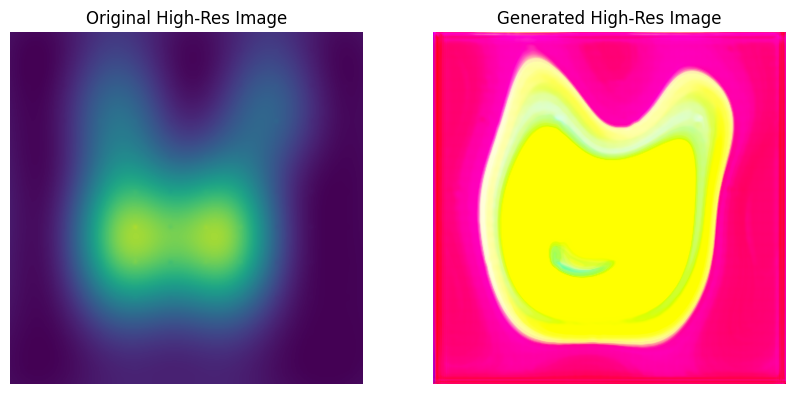

In [ ]:
# Function to load low-resolution and high-resolution images from the given paths
def load_images(low_res_path, high_res_path):
    low_res_image = cv2.imread(low_res_path)  # Load low-res image
    high_res_image = cv2.imread(high_res_path)  # Load high-res image
    return low_res_image, high_res_image

# Function to generate a high-resolution image from low-resolution input using the trained generator model
def generate_high_res_image(generator, low_res_image):
    # Convert the image to PyTorch tensor, add a batch dimension and move it to the CPU
    low_res_image = torch.from_numpy(low_res_image).permute(2, 0, 1).unsqueeze(0).float()
    
    # Move the image to the CPU
    low_res_image = low_res_image.to('cpu')
    
    # Ensure the generator is in evaluation mode
    generator.eval()
    
    # Move the generator model to CPU
    generator = generator.to('cpu')

    # Generate the high-resolution image using the generator
    with torch.no_grad():
        generated_high_res = generator(low_res_image)
    
    # Squeeze the batch dimension and convert the tensor back to a NumPy array for visualization
    generated_high_res = generated_high_res.squeeze(0).permute(1, 2, 0).cpu().numpy()

    return generated_high_res


# Define the paths to the low-resolution and high-resolution images
low_res_image_path = 'kriging_low\lr_0.png'  # Provide path to your low-resolution image
high_res_image_path = 'kriging_high\hr_0.png'  # Provide path to the corresponding high-resolution image

# Load the low-resolution and high-resolution images
low_res_image, original_high_res_image = load_images(low_res_image_path, high_res_image_path)

# Generate the high-resolution image from the low-resolution image
generated_high_res_image = generate_high_res_image(generator, low_res_image)

# Display the original and generated high-resolution images for comparison
import matplotlib.pyplot as plt

# Create a figure for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original high-resolution image
axes[0].imshow(cv2.cvtColor(original_high_res_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original High-Res Image")
axes[0].axis("off")

# Display the generated high-resolution image
axes[1].imshow(cv2.cvtColor(generated_high_res_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Generated High-Res Image")
axes[1].axis("off")

# Show the comparison plot
plt.show()
